# Trabalho Final - Avaliação e Desempenho 2022.1
## Grupo:
- Matheus Fernandes Cabral - DRE: 116033208
- Rafael da Silva Fernandes - DRE: 117196229
- Stephanie Orazem Hoegemann Ramos - DRE: 113278168

## Objetivo 
O foco deste trabalho de simulação será a implementação de uma simulação orientada a eventos discretos e que permita a obtenção de intervalos de confiança para algumas métricas de uma fila M/M/1, usando as disciplinas de atendimento entre FCFS e LCFS.

## Descrição dos eventos

### Chegada

- Insere o freguês na fila de fregueses que chegaram ao sistema
- Programa um evento de chegada na fila de eventos, tempo dependendo da taxa de chegada Poisson
    - Se fila vazia:
        - programa um evento de entrada no serviço da fila de eventos, com o mesmo tempo dessa chegada
    - Do contrário:
        - insere o freguês na fila de espera

### Entrada em serviço

- Programa um evento de saída do serviço, com o tempo dado pela distribuição exponencial do serviço.
- Coleta estatísticas sobre o tempo de espera na fila

### Saída de serviço

- Coleta estatísticas sobre o tempo de serviço
- Se a fila não estiver vazia, programa um evento de entrada em serviço na fila de eventos, com o mesmo tempo da saída de serviço

> ToDo:
- calcular valor central de cada IC
    - calcular sobreposição dos ICs pelas duas metodologias e comparar
- testes de correção

## Bibliotecas utilizadas

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2, t

## Variáveis globais

In [30]:
# Inicialização do identificador único dos fregueses
CUSTOMER_ID = 0

# Booleano para indicar se o servidor está ocupado (True) ou não (False)
BUSY_SERVER = False

# Número de rodadas, definido pelo enunciado do trabalho
N_ROUNDS = 3200

# Número de coletas por rodada >> 1, para que a média do tempo de espera por rodada possa ser assumido como distribuição Normal
KMIN = 100

# Lista com as sementes a serem trabalhadas
SEEDS = [4242564, 4510471, 1492, 365, 23564, 4649, 59, 893, 18782]

# Lista com os valores de lambda a serem trabalhos
LAMBDAS = [0.2, 0.4, 0.6, 0.8, 0.9]

## Classes

### Freguês

In [31]:
class Customer:
    '''
    Atributos do freguês:
    - id: identificador único de cada freguês
    - arrival_time: tempo de chegada no sistema
    - entry_server_time: tempo de entrada em serviço
    - exit_server_time: tempo de saída do serviço
    - arrival_round: rodada em que o freguês chega
    '''

    def __init__(self, id, arrival_time, arrival_round):
        self.id = id
        self.arrival_time = arrival_time
        self.arrival_round = arrival_round
        self.entry_server_time = 0
        self.exit_server_time = 0

### Estatísticas

In [32]:
class Statistics:
    '''
    Somatório das estatísticas, sendo elas:
    - tempo de serviço
    - tempo de espera na fila
    - tempo total gasto no sistema
    '''

    def __init__(self):
        self.sample_index = 0
        self.sample_service_time = 0
        self.sample_queue_time = 0
        self.sample_system_time = 0
        self.mean_queue_wait = 0

    
    def statistics_accumulator(self, customer):
        self.sample_index += 1
        self.sample_service_time += customer.exit_server_time - customer.entry_server_time
        self.sample_queue_time += customer.entry_server_time - customer.arrival_time
        self.sample_system_time += customer.exit_server_time - customer.arrival_time

    
    def mean_calculator(self):
        '''
        Método responsável pelo cálculo da média do tempo de espera na fila
        '''
        self.mean_queue_wait = self.sample_queue_time/ self.sample_index

### Utilitários

In [33]:
class Utils:

    def append_event(event, event_list):
        '''
        Adiciona evento à lista de eventos
        '''
        
        for i in range(len(event_list)):
            
            # Caso o evento na posição i da lista de eventos tenha um tempo de início superior ao do evento passado como parâmetro
            # Nós inserimos o evento passado como parâmetro na posição i da lista, substituindo assim o original
            if(event_list[i].start_time >= event.start_time):
                event_list.insert(i, event)
                return
        
        event_list.append(event)


    def find_customer(customer_list, id):
        '''
        Encontra freguês na lista de fregueses com o id passado como parâmetro 
        '''

        for customer in range(len(customer_list)):
            if(customer_list[customer].id == id):
                return customer

        return None


    def generate_arrival_time(lambda_rate):
        '''
        Calcula tempo de chegada com base na taxa lambda passada como parâmetro
        '''
        
        u0 = np.random.uniform()
        t0 = np.log(u0)/ (-lambda_rate)

        return t0


    def generate_service_time():
        '''
        Calcula tempo de serviço com taxa igual à 1, pois foi dada na descrição do trabalho
        '''

        u0 = np.random.uniform()
        x0 = np.log(u0)/ (-1)

        return x0


    def variance_queue_wait_confidence_interval(estimated_variance):
        '''
        Cálculo do Intervalo de Confiança (IC) utilizando a distribuição chi-quadrado
        '''

        # Cálculo dos limites inferior e superior
        superior_limit = ((N_ROUNDS - 1) * estimated_variance)/ chi2.ppf(q = 0.025, df = N_ROUNDS - 1)
        inferior_limit = ((N_ROUNDS - 1) * estimated_variance)/ chi2.ppf(q = 0.975, df = N_ROUNDS - 1)

        # Cálculo da precisão
        chi_sup = chi2.ppf(q = 0.025, df = N_ROUNDS - 1)
        chi_inf = chi2.ppf(q = 0.975, df = N_ROUNDS - 1)
        precision = (chi_inf - chi_sup)/ (chi_sup + chi_inf)

        return inferior_limit, superior_limit , precision


    def mean_queue_wait_confidence_interval(standard_deviation, estimated_mean):
        '''
        Cálculo do IC usando a distribuição t-student
        '''

        # Cálculo dos limites inferior e superior
        superior_limit = estimated_mean + (t.ppf(q = 0.975, df = N_ROUNDS - 1) * (standard_deviation/ np.sqrt(N_ROUNDS))) 
        inferior_limit = estimated_mean - (t.ppf(q = 0.975, df = N_ROUNDS - 1) * (standard_deviation/ np.sqrt(N_ROUNDS)))
        
        # Cálculo da precisão
        precision = (superior_limit - inferior_limit)/ (superior_limit + inferior_limit)
        
        return inferior_limit, superior_limit, precision

### Evento

In [34]:
class Event:
    '''
    Atributos de cada evento:
    - event_type: tipo do evento
        - chegada no sistema (CH)
        - entrada em serviço (ES)
        - saída de serviço (SS)
    - start_time: tempo de início do evento
    - customer_index: índice do freguês a qual o evento se refere
    '''

    def __init__(self, event_type, start_time, customer_index):
        self.event_type = event_type
        self.start_time = start_time
        self.customer_index = customer_index

    
    def queue_arrival(self, customer_list, event_list, wait_queue, current_round, lambda_rate):
        '''
        Fila de chegada
        '''

        # Permite alterar o valor da variável global CUSTOMER_ID dentro da função
        global CUSTOMER_ID

        # Calcula tempo de chegada para freguês com identificador igual à CUSTOMER_ID
        arrival_time = self.start_time + Utils.generate_arrival_time(lambda_rate)

        # Incrementa índice do freguês, o instancia e adiciona na lista de fregueses
        CUSTOMER_ID += 1
        customer_list.append(Customer(CUSTOMER_ID, arrival_time, current_round))

        # Adiciona chegada no sistema à fila de eventos
        Utils.append_event(Event('CH', arrival_time, CUSTOMER_ID), event_list)

        # Caso não haja ninguém na fila de espera e o servidor não esteja vazio
        # Adiciona entrada em serviço à fila de eventos
        if(len(wait_queue) == 0 and not BUSY_SERVER):
            Utils.append_event(Event('ES', self.start_time, self.customer_index), event_list)
        
        # Caso contrário, adiciona freguês à lista de espera
        else:
            wait_queue.append(self.customer_index)


    def service_entry(self, customer_list, event_list, wait_queue, FCFS = True):
        '''
        Calcula a entrada do serviço
        '''

        global BUSY_SERVER

        # Caso a fila não esteja vazia, pega-se o freguês com base na disciplina
        if(len(wait_queue) > 0):
            
            # Com base em FCFS, pega-se o primeiro freguês
            if(FCFS):
                wait_queue.pop(0)
            # Com base em LCFS, pega-se o último freguês
            else:
                wait_queue.pop(-1)
        
        # Calcula tempo de serviço total
        service_time = self.start_time + Utils.generate_service_time()
        
        # Adiciona saída de serviço à fila de eventos
        Utils.append_event(Event('SS', service_time, self.customer_index), event_list)

        # Sinaliza que o servidor está ocupado
        BUSY_SERVER = True

        # Relaciona o freguês com o seu tempo de serviço
        customer_list[Utils.find_customer(customer_list, self.customer_index)].entry_server_time = self.start_time


    def service_exit(self, customer_list, event_list, wait_queue, statistics, current_round, FCFS = True):
        '''
        Calcula a saída do serviço
        '''

        global BUSY_SERVER

        # Caso a fila não esteja vazia, adiciona entrada em serviço à fila de eventos
        if(len(wait_queue) > 0):
            # Com base em FCFS
            if(FCFS):
                Utils.append_event(Event('ES', self.start_time, wait_queue[0]), event_list)
            # Com base em LCFS
            else:
                Utils.append_event(Event('ES', self.start_time, wait_queue[-1]), event_list)

        # Sinaliza que o servidor não está ocupado
        BUSY_SERVER = False

        # Calcula as estatísticas do freguês e o remove da lista de fregueses 
        aux_customer_id = Utils.find_customer(customer_list, self.customer_index)
        customer_list[aux_customer_id].exit_server_time = self.start_time
        statistics[current_round].statistics_accumulator(customer_list[aux_customer_id])
        customer_list.pop(aux_customer_id)

## Execução do simulador

### Fluxo principal

In [35]:
def main(lambda_rate, FCFS = True):

    # Inicialização das variáveis média e desvios quadrados estimados para o tempo na fila de espera
    wait_queue_time_estimated_mean, wait_queue_time_estimated_variance = 0, 0

    # Inicialização das variáveis média e desvios quadrados estimados para o número na fila de espera
    wait_queue_number_estimated_mean, wait_queue_number_estimated_variance = 0, 0

    # Listas:
    # Lista dos eventos | Lista dos fregueses | Fila de espera | Estatísticas | Tempo de espera | Número de fregueses na fila de espera
    event_list, customer_list, wait_queue, statistics, W, Nq = [], [], [], [], [], []
    
    # Definindo a primeira chegada no sistema
    FIRST_CUSTOMER = Customer(0, 0, 0)
    customer_list.append(FIRST_CUSTOMER)
    FIRST_ARRIVAL = Event('CH', 0, 0)
    event_list.append(FIRST_ARRIVAL)

    # Iteração sobre o número de rodadas igual à N_ROUNDS
    for current_round in range(N_ROUNDS):

        # Inicia estatísticas para os tempos totais gastos pelo simulador
        statistics.append(Statistics())

        # Iteração sobre o número de coletas igual à KMIN
        while(statistics[current_round].sample_index < KMIN):
            
            # Pega primeiro evento da lista de eventos
            current_event = event_list.pop(0)

            # Caso o tipo do evento seja chegada ao sistema
            if(current_event.event_type == 'CH'):
                current_event.queue_arrival(customer_list, event_list, wait_queue, current_round, lambda_rate)

            # Caso o tipo do evento seja entrada em serviço
            elif(current_event.event_type == 'ES'):
                current_event.service_entry(customer_list, event_list, wait_queue, FCFS)

            # Caso o tipo do evento seja saída do serviço
            elif(current_event.event_type == 'SS'):
                current_event.service_exit(customer_list, event_list, wait_queue, statistics, current_round, FCFS)


        # Cálcula média das estatísticas para a rodada atual
        statistics[current_round].mean_calculator()

        # Calculando tempo médio na fila de espera, e adicionado-o à lista W
        W.append(statistics[current_round].mean_queue_wait/ (CUSTOMER_ID + 1))

        # Calculando número médio de pessoas na fila de espera, e adicionado-o à lista Nq
        Nq.append(len(customer_list)/ (CUSTOMER_ID + 1))


    # Dicionário para os resultados que devem ser retornados
    results_dict = {}

    # Métricas para o tempo na fila de espera
    # Cálculo da média estimada para o tempo na fila de espera
    for statistic in statistics:
        wait_queue_time_estimated_mean += statistic.mean_queue_wait
    results_dict["Queue time estimated mean"] = wait_queue_time_estimated_mean

    # Cálculo da média real para o tempo na fila de espera
    wait_queue_time_real_mean = wait_queue_time_estimated_mean/ N_ROUNDS
    results_dict["Queue time real mean"] = wait_queue_time_real_mean

    # Cálculo dos desvios quadrados para o tempo na fila de espera
    for statistic in statistics:
        wait_queue_time_estimated_variance += (statistic.mean_queue_wait - wait_queue_time_real_mean) ** 2
    results_dict["Queue time estimated variance"] = wait_queue_time_estimated_variance

    # Cálculo da variância para o tempo na fila de espera
    wait_queue_time_variance = wait_queue_time_estimated_variance/ (N_ROUNDS - 1)
    results_dict["Queue time variance"] = wait_queue_time_variance

    # Cálculo dos limites inferior, superior e precisão da distribuição chi-quadrado para o tempo na fila de espera
    chi_inf_limit, chi_sup_limit, chi_precision = Utils.variance_queue_wait_confidence_interval(wait_queue_time_variance)
    results_dict["Queue time Chi Inferior limit"] = chi_inf_limit
    results_dict["Queue time Chi Superior limit"] = chi_sup_limit
    results_dict["Queue time Chi Precision"] = chi_precision

    # Cálculo dos limites inferior, superior e precisão da distribuição t-student para o tempo na fila de espera
    t_inf_limit, t_sup_limit, t_precision = Utils.mean_queue_wait_confidence_interval(\
        np.sqrt(wait_queue_time_variance), wait_queue_time_real_mean
    )
    results_dict["Queue time T Student Inferior limit"] = t_inf_limit
    results_dict["Queue time T Student Superior limit"] = t_sup_limit
    results_dict["Queue time T Student Precision"] = t_precision


    # Métricas para o número na fila de espera
    # Cálculo do número médio estimado na fila de espera
    wait_queue_number_estimated_mean = np.sum(Nq)
    results_dict["Queue number estimated mean"] = wait_queue_number_estimated_mean 

    # Cálculo do número médio real na fila de espera
    wait_queue_number_real_mean = np.mean(Nq)
    results_dict["Queue number real mean"] = wait_queue_number_real_mean

    # Cálculo dos desvios quadrados para o número na fila de espera
    for statistic in statistics:
        wait_queue_number_estimated_variance += (statistic.mean_queue_wait - wait_queue_number_real_mean) ** 2
    results_dict["Queue number estimated variance"] = wait_queue_number_estimated_variance

    # Cálculo da variância para o número na fila de espera
    wait_queue_number_variance = wait_queue_number_estimated_variance/ (N_ROUNDS - 1)
    results_dict["Queue number variance"] = wait_queue_number_variance

    # Cálculo dos limites inferior, superior e precisão da distribuição chi-quadrado para o número na fila de espera
    chi_inf_limit, chi_sup_limit, chi_precision = Utils.variance_queue_wait_confidence_interval(wait_queue_number_variance)
    results_dict["Queue number Chi Inferior limit"] = chi_inf_limit
    results_dict["Queue number Chi Superior limit"] = chi_sup_limit
    results_dict["Queue number Chi Precision"] = chi_precision

    # Cálculo dos limites inferior, superior e precisão da distribuição t-student para o número na fila de espera
    t_inf_limit, t_sup_limit, t_precision = Utils.mean_queue_wait_confidence_interval(\
        np.sqrt(wait_queue_number_variance), wait_queue_number_real_mean
    )
    results_dict["Queue number T Student Inferior limit"] = t_inf_limit
    results_dict["Queue number T Student Superior limit"] = t_sup_limit
    results_dict["Queue number T Student Precision"] = t_precision

    # Transformando o dicionário em um DataFrame
    results_dataframe = pd.DataFrame.from_dict(results_dict, orient = "index")

    # Configurações gerais do gráfico
    plt.xlabel("Número de rodadas")
    plt.ylabel("Média do número de fregueses na fila de espera")

    # Configurações do gráfico da média do tempo na fila de espera
    plt.title("Média do tempo na fila de espera a cada rodada")
    plt.plot(W)
    plt.show()

    # Configurações do gráfico da média de fregueses na fila de espera a cada rodada
    plt.title("Média do número de fregueses na fila de espera a cada rodada")
    plt.plot(Nq)
    plt.show()

    return results_dataframe

### Resultados

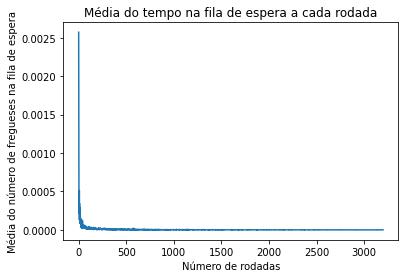

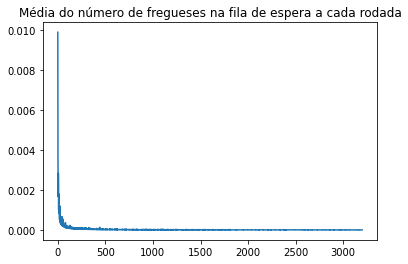

,0
Queue time estimated mean,789.721657
Queue time real mean,0.246788
Queue time estimated variance,42.734991
Queue time variance,0.013359
Queue time Chi Inferior limit,0.012728
Queue time Chi Superior limit,0.014038
Queue time Chi Precision,0.048975
Queue time T Student Inferior limit,0.242782
Queue time T Student Superior limit,0.250794
Queue time T Student Precision,0.016233


In [36]:
main(0.2)

#### FCFS

In [37]:
# %%time
# # Inicializa DataFrame para os resultados da disciplina FCFS
# results_fcfs = pd.DataFrame()

# # KMIN vai de 100 à 1000, sendo incrementado de 100 em 100
# while(KMIN <= 1000):
#     for seed in SEEDS:
#         np.random.seed(seed)
        
#         for lambda_rate in LAMBDAS:
#             results_fcfs["Lambda = " + str(lambda_rate)] = main(lambda_rate)

#         # Renomeando índice da tabela para mostrar qual foram os valores da seed de KMIN utilizados
#         results_fcfs.rename_axis("Seed = " + str(seed) + " | K = " + str(KMIN), inplace = True)
        
#         # Imprimindo tabelas
#         display(results_fcfs)

#     KMIN += 100

#### LCFS

In [38]:
# %%time
# # Reinicia o valor de KMIN
# KMIN = 100

# # Inicializa DataFrame para os resultados da disciplina LCFS
# results_lcfs = pd.DataFrame()

# # KMIN vai de 100 à 1000, sendo incrementado de 100 em 100
# while(KMIN <= 1000):
#     for seed in SEEDS:
#         np.random.seed(seed)
        
#         for lambda_rate in LAMBDAS:
#             results_lcfs["Lambda = " + str(lambda_rate)] = main(lambda_rate, FCFS = False)

#         # Renomeando índice da tabela para mostrar qual foi o valor de KMIN utilizado
#         results_lcfs.rename_axis("Seed = " + str(seed) + " | K = " + str(KMIN), inplace = True)

#         # Imprimindo tabelas
#         display(results_lcfs)

#     KMIN += 100

## Questões

### a) Tempo médio de espera em fila

#### FCFS

In [39]:
# results_fcfs.iloc[1]

#### LCFS

In [40]:
# results_lcfs.iloc[1]

### b) Variância do tempo de espera em fila

#### FCFS

In [41]:
# results_fcfs.iloc[3]

#### LCFS

In [42]:
# results_lcfs.iloc[3]

### c) Número médio na fila de espera

#### FCFS

In [43]:
# results_fcfs.iloc[11]

#### LCFS

In [44]:
# results_fcfs.iloc[11]

### d) Variância do número de pessoas na fila de espera

#### FCFS

In [45]:
# results_fcfs.iloc[13]

#### LCFS

In [46]:
# results_fcfs.iloc[13]